<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/DMR_Single_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) one domain, (2) pure homogeneous Neumann, (3) Allow surface diffusion 

# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2017-11-18

# This demo is maintained by Van-Dang Nguyen
# Please report problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [4]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# Define some parameters

In [0]:
bvalue = 5000;             # bvalue
delta, Delta = 40000, 40000 # PGSE sequence
g0, g1, g2 = 1, 0, 0;       # gradient direction
K = 3e-3;                   # Diffusion coefficient
nskip = 5;                  # Output frequency (for visualization only)
porder = 1;                 # order of basis functions of FEM
Nsteps = 200;               # number of time intervals

# Define a mesh

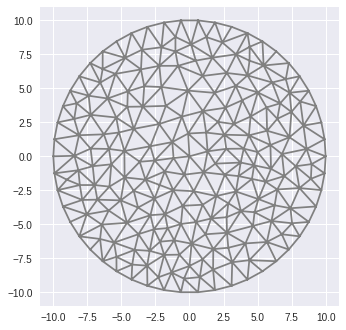

In [7]:
xc = 0;
yc = 0;
r = 10;
mresolution = 10;
domain = Circle(Point(xc, yc), r, int(r*5));
mesh = generate_mesh(domain, mresolution);
gdim = mesh.geometry().dim()

plot(mesh)

# Solve the Bloch-Torrey equation

mesh.hmin:  1.0955369021543033 mesh.hmax:  1.9985660198144442
t: 0.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 0.00%
t: 2000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 2.49%
t: 4000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 4.98%
t: 6000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 7.46%
t: 8000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 9.95%
t: 10000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 12.44%
t: 12000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 14.93%
t: 14000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 17.41%
t: 16000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 19.90%
t: 18000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 22.39%
t: 20000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 24.88%
t: 22000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Completed 27.36%
t: 24000.000000  T: 80000.0 dt:400.0 gnorm: 1.082532e-05 Comple

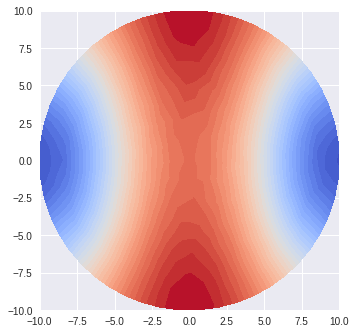

In [9]:
if (Delta-delta/3.0<=0):
    print('Check time sequence!');
    exit(0);
gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
t, T = 0, Delta+delta;

## FUNCTION SPACES
if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh , "CG", porder); # order 1, 2 components
    W = MixedFunctionSpace([V, V])
else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh,Ve);
    TH = MixedElement([Ve,Ve])
    W = FunctionSpace(mesh, TH)


v = TestFunction(W)
v1r, v1i = v[0], v[1]

u = TrialFunction(W);
u1r, u1i = u[0], u[1]

# Initial conditions
if (gdim==2):
  Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mesh, degree=2);
if (gdim==3):
  Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mesh, degree=2);
Dirac_Delta = project(Dirac_Delta, V);
u_0 = Function(W);
assign(u_0.sub(0), Dirac_Delta)
u1r_0, u1i_0 = split(u_0)

if (gdim==2):
  GX=Expression("x[0]*g0+x[1]*g1", g0=g0, g1=g1, domain=mesh, degree=3);
if (gdim==3):
  GX=Expression("x[0]*g0+x[1]*g1+x[2]*g2", g0=g0, g1=g1, g2=g2, domain=mesh, degree=3);

def FT(t, delta, Delta):
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
    return ft1 + ft2;  

def iFT(t, delta, Delta): # integrate ft
    ft1 = t*(t>=0 and t<delta) 
    ft2 = delta*(t>=delta and t<Delta) 
    ft3 = (delta - t + Delta)*(t>=Delta and t<=Delta+delta) 
    return ft1 + ft2 + ft3;  
stepcounter = 0;

## Theta method
def FuncF(ft, gnorm, GX, ur, ui, vr, vi, K):
    Fr = ft*gnorm*GX*ui*vr - K*inner(grad(ur), grad(vr))
    Fi = - ft*gnorm*GX*ur*vi - K*inner(grad(ui), grad(vi))
    return Fr + Fi

def ThetaMethod_L(ft, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta):
    L1 = (u1r_0/k*v1r +u1i_0/k*v1i+(1-theta)*FuncF(ft, gnorm, GX, u1r_0, u1i_0, v1r, v1i, K))*dx
    return L1

def ThetaMethod_a(ft, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta):
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ft, gnorm, GX, u1r  , u1i  , v1r, v1i, K))*dx
    return a1

def NoTimeMatrices(u1r, u1i, v1r, v1i, K, GX, theta):
    m1 = (u1r*v1r   + u1i*v1i)*dx
    M = assemble(m1);
    j1 = -GX*(u1i*v1r   - u1r*v1i)*dx
    J = assemble(j1);    
    s1 = K*( inner(grad(u1r), grad(v1r)) + inner(grad(u1i), grad(v1i)) )*dx
    S = assemble(s1)
    return M, J, S

def ThetaMethod_A(ft, gnorm, theta, k, M, J, S):
    return 1./k*M + ft*gnorm*theta*J + theta*S

theta = 0.5;

k = T/Nsteps;

hmin = mesh.hmin();

# h = CellSize(mesh);
h=Circumradius(mesh);

print('mesh.hmin: ', hmin,'mesh.hmax: ',mesh.hmax());

M, J, S = NoTimeMatrices(u1r, u1i, v1r, v1i, K, GX, theta);

stepcounter = 0;

ft_prev = FT(t, delta, Delta);

while t < T + k: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%T, 'dt:%.1f'%k,'gnorm: %e'%gnorm,'Completed %.2f%%'%(float(t)/float(T+k)*100.0));
    ft = FT(t, delta, Delta);
    ift = iFT(t, delta, Delta);
    L = ThetaMethod_L(ft_prev, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta);
    # A = ThetaMethod_A(ft, gnorm, theta, k, M, J, S);
    a = ThetaMethod_a(ft, gnorm, GX, u1r, u1i, v1r, v1i,k, K, theta);
    A = assemble(a);
    b = assemble(L);
    u = Function(W)
    solve(A,u.vector(),b, "gmres", "ilu");
    u1r_0, u1i_0 = split(u)
    ft_prev = ft;
    t += k;
    stepcounter += 1;

signal = assemble(u1r_0*dx)/assemble(Dirac_Delta*dx);
print('b:',bvalue, 'Signal: %.3e'%signal,', dt:',k,', hmin:',hmin)


u1r_0p = project(u1r_0, V);
u1i_0p = project(u1i_0, V);

File('RealSol.pvd')<<u1r_0p;
File('ImagSol.pvd')<<u1i_0p;

plot(u1r_0p, cmap="coolwarm")

# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # R=10, delta=Delta=40000
#  bvalue  # signal attenuation
# # # # # # # # # # # # # # #
# 0.00e+00 # 1.00e+00
# 1.00e+03 # 7.43e-01
# 2.00e+03 # 5.46e-01
# 3.00e+03 # 3.96e-01
# 4.00e+03 # 2.84e-01
# 5.00e+03 # 2.00e-01
# 6.00e+03 # 1.38e-01
# 7.00e+03 # 9.32e-02
# 8.00e+03 # 6.15e-02
# 9.00e+03 # 3.95e-02
# 1.00e+04 # 2.46e-02
# # # # # # # # # # # # # # #


